# Imports

In [118]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

import cleaning_utils as cl
import analysis_utils as als

sns.set(rc = {'figure.figsize': (15, 5)})

In [120]:
files = ['clients', 'produits', 'ventes', 'fusion']
[clients, products, sales, fusion] = cl.imports_csv('CURATED', files)

In [121]:
fusion

client_id sex  birth id_prod                        date session_id  \
0         c_4410   f   1967  0_1455  2021-03-22 14:29:25.189266     s_9942   
1         c_4389   m   1984  0_1455  2021-07-09 11:16:18.579726    s_59967   
2         c_5019   f   1977  0_1455  2022-01-15 00:01:53.456196   s_149928   
3         c_7049   f   1987  0_1455  2021-03-04 14:01:38.698752     s_1637   
4         c_5110   f   1982  0_1455  2021-09-05 11:48:41.065009    s_85364   
...          ...  ..    ...     ...                         ...        ...   
336708    c_7135   m   1996    2_99  2021-07-11 20:56:49.820935    s_61009   
336709    c_5828   f   1998    2_99  2021-11-21 01:53:46.967570   s_122697   
336710    c_8260   m   1991   0_833  2021-09-27 23:22:40.394509    s_96558   
336711    c_8138   f   1984   0_394  2021-11-09 09:02:38.299240   s_116986   
336712    c_8327   m   1972   0_394  2021-12-28 22:44:11.200205   s_141516   

        price  categ  
0        8.99      0  
1        8.99      0  
2        8.99      0  
3        8.99      0  
4        8.99      0  
...       ...    ...  
336708  84.99      2  
336709  84.99      2  
336710   2.99      0  
336711   2.14      0  
336712   2.14      0  

[336713 rows x 8 columns]

# Measure of central tendency and dispertion

In [122]:
als.indicators(fusion.birth)

mean : 	 1977.8235678456133
std : 	 13.524433308700143
median : 1980.0
iqr: 	 16.0
mode :	 [1980]


In [123]:
als.indicators(fusion.price)

mean : 	 17.215188513723316
std : 	 17.855445377653425
median : 13.9
iqr: 	 10.379999999999999
mode :	 [15.99]


In [124]:
als.indicators(fusion.sex)

mode :	 ['m']


In [125]:
fusion.categ = fusion.categ.astype(str)
als.indicators(fusion.categ)

mode :	 ['0']


# Outliers

**Looking at the number of sales for each client**

<AxesSubplot:xlabel='date'>

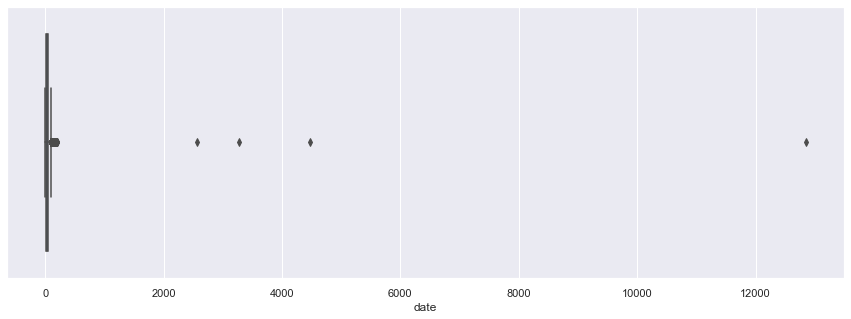

In [126]:
sales_by_client = fusion.groupby('client_id')['date'].count().sort_values(ascending = False)
sns.boxplot(sales_by_client)

**There are four clients that have done an extraordinary amount of orders.**

**Their numbers may heavily influence our analysis and biaise the final results**

**We then decide to remove them for the rest of our analysis**

In [127]:
zscore= (sales_by_client - sales_by_client.mean()) / sales_by_client.std()

In [128]:
top_buyers = sales_by_client[zscore > 2]
top_buyers.index

Index(['c_1609', 'c_6714', 'c_3454', 'c_4958'], dtype='object', name='client_id')

In [129]:
fusion = fusion[fusion['client_id'].isin(top_buyers.index) == False]

# Concentration analysis

## Lorenz curve and Gini score

**Looking at the repartition of the money spend for each client**

**The Lorenz curve and Gini score will show us how much inequality there is in our series**

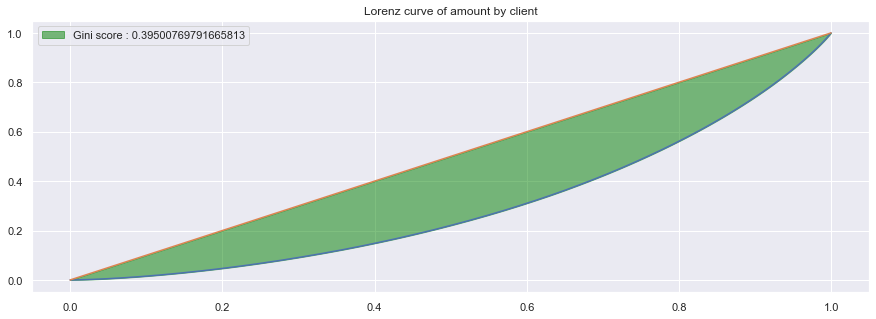

In [130]:
amount_by_clients = fusion.groupby('client_id')['price'].sum()
als.lorenz(amount_by_clients, 'Lorenz curve of amount by client', gini = True)

**As shown above, the amount spent is quite uneven  between the different clients**

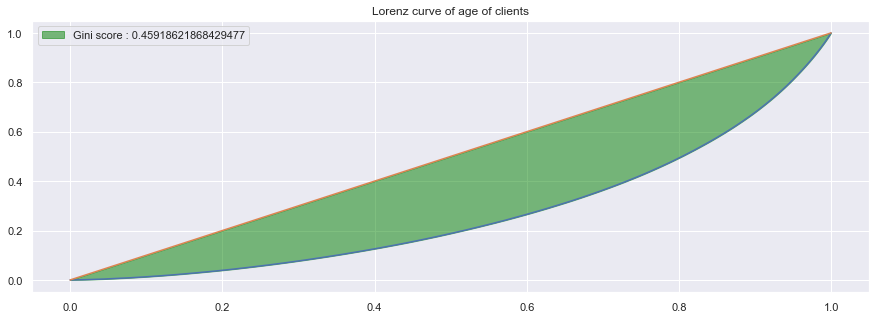

In [131]:
age_clients = fusion.groupby('client_id')['birth'].count()
als.lorenz(age_clients,'Lorenz curve of age of clients', gini = True)

**The disparity in the amount spent might be linked to the age of the clients**

# Visualisation

**For this part we'll look at different things and we need a few added features to our dataset**

## `age` feature from `birth`

In [132]:
fusion['age'] = datetime.date.today().year - fusion['birth']

In [133]:
by_age = fusion.groupby('age')['age'].count()

**We can imagine that clients in their active life (30 - 50) would be most likely to buy products**

<AxesSubplot:xlabel='age'>

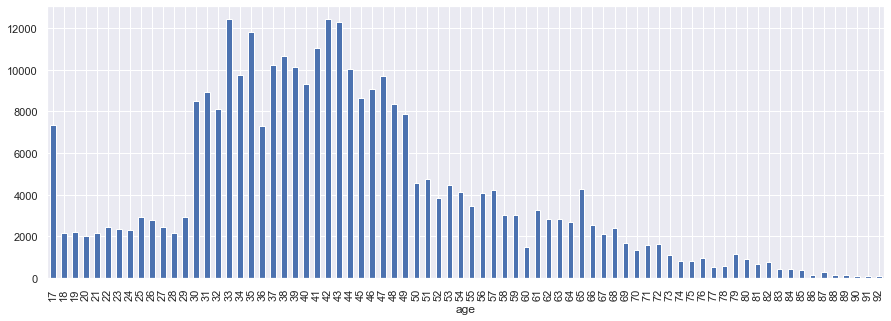

In [134]:
by_age.plot.bar()

**As shown above, clients in their mid-life are indeed buying more products**

## `categ` by `sex`
**We want to see if a sex likes to buy a particular product**

<AxesSubplot:xlabel='categ', ylabel='Count'>

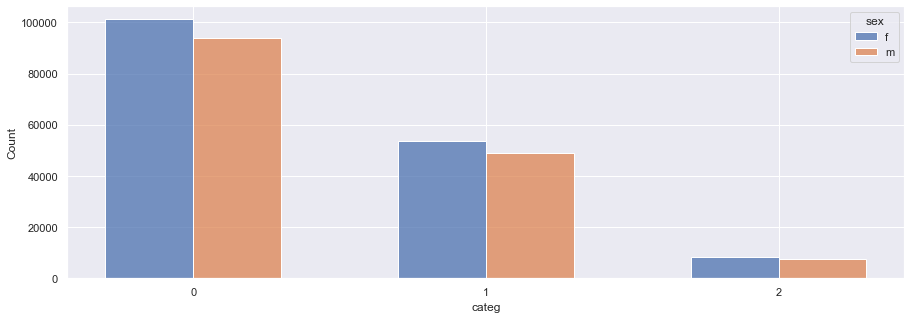

In [135]:
sns.histplot(fusion, x='categ', hue='sex', multiple='dodge', shrink=0.6)

In [136]:
fusion['status'] = pd.cut(fusion.age, [0, 30, 50, fusion['age'].max()], labels=['junior (30-)', 'adult (31,50)', 'senior (50+)'])

<AxesSubplot:xlabel='categ', ylabel='Count'>

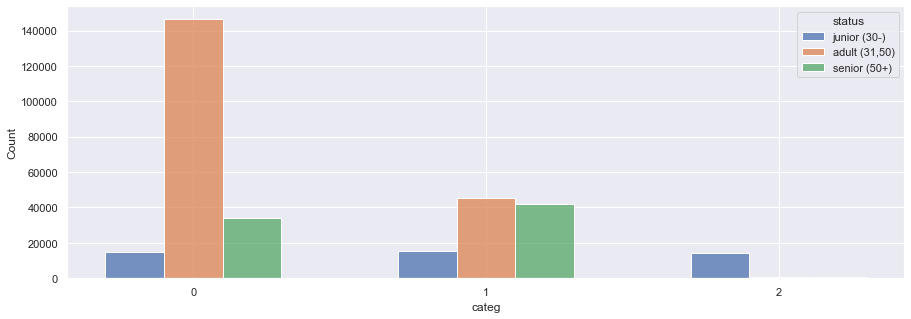

In [137]:
sns.histplot(fusion, x='categ', hue='status', multiple='dodge', shrink=0.6)

<AxesSubplot:xlabel='age', ylabel='price'>

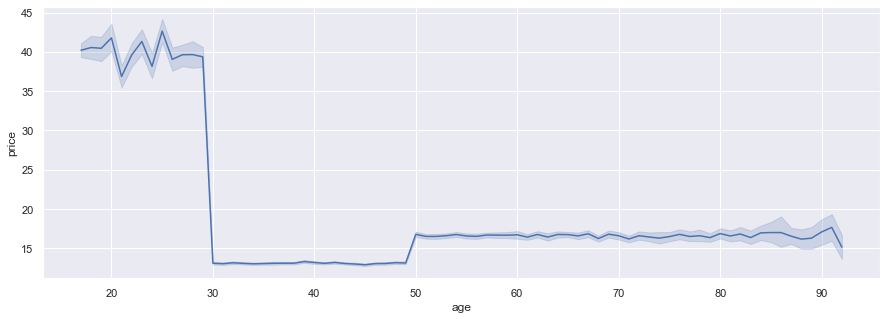

In [138]:
sns.lineplot(data = fusion, x= 'age', y= 'price')

<AxesSubplot:xlabel='price'>

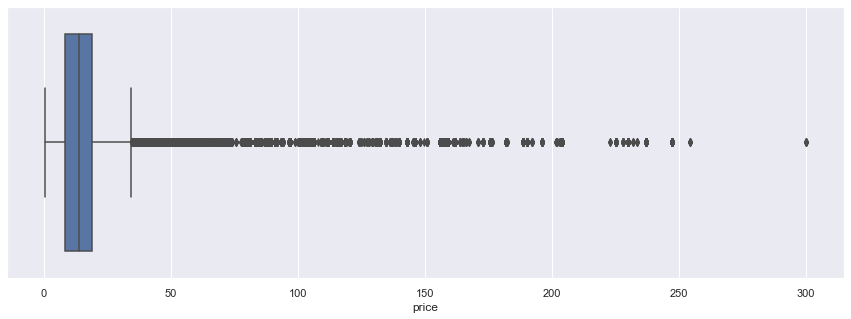

In [139]:
sns.boxplot(fusion['price'])

# Création d'une série temporelle

In [140]:
fusion = als.feature_time_series(fusion)

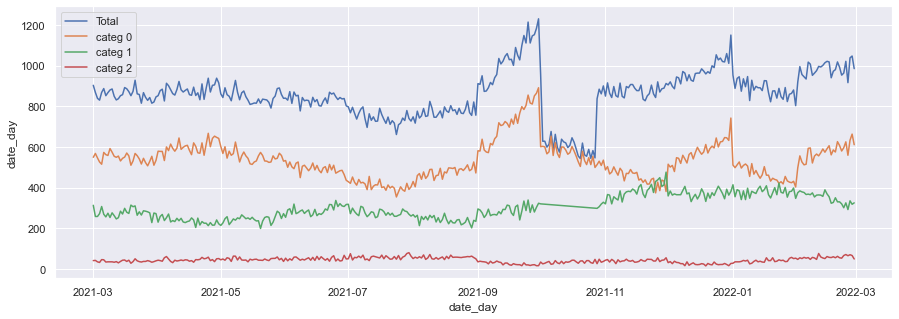

In [141]:
als.plot_categ_time(fusion)

In [142]:
ommit_fusion = als.ommit_october(fusion)

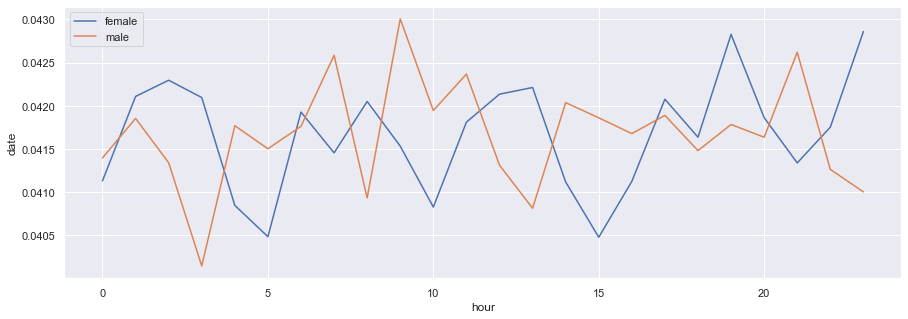

In [143]:
als.habits_hour_sex(ommit_fusion)

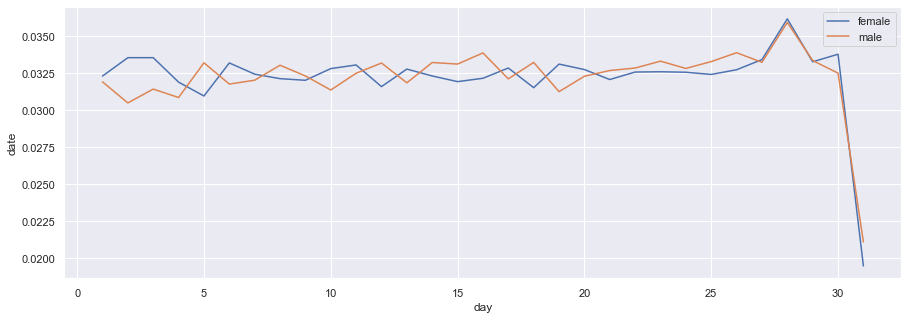

In [144]:
als.habits_day_sex(ommit_fusion)

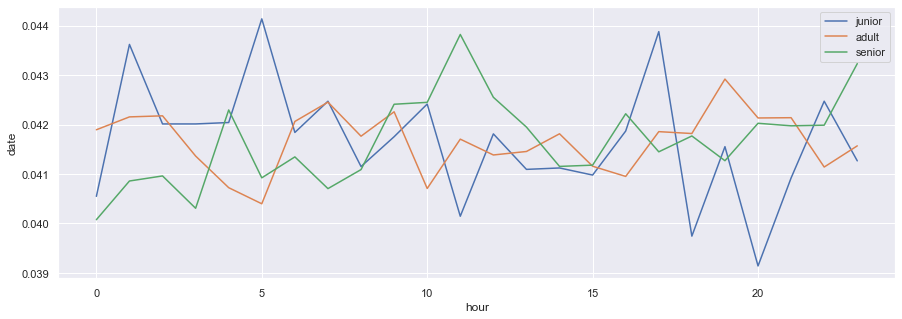

In [145]:
als.habits_hours_age(ommit_fusion)

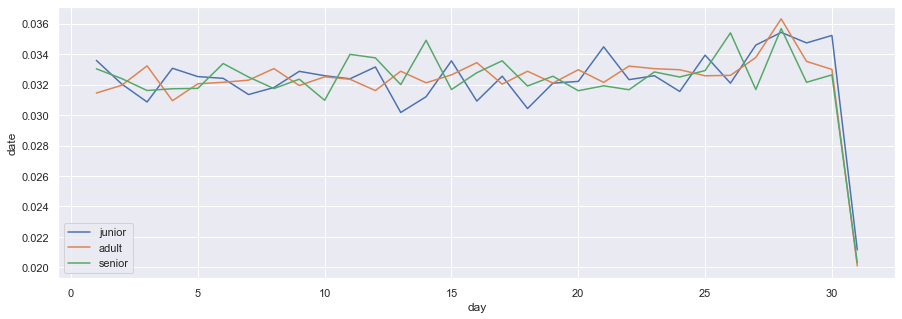

In [146]:
als.habits_day_age(ommit_fusion)

# Bivariate analysis

In [147]:
correl = fusion[['age', 'price', 'categ', 'sex']]
correl['sex'] = correl['sex'].map({'m': 0, 'f': 1})
correl['categ'] = correl['categ'].astype(int)

<AxesSubplot:>

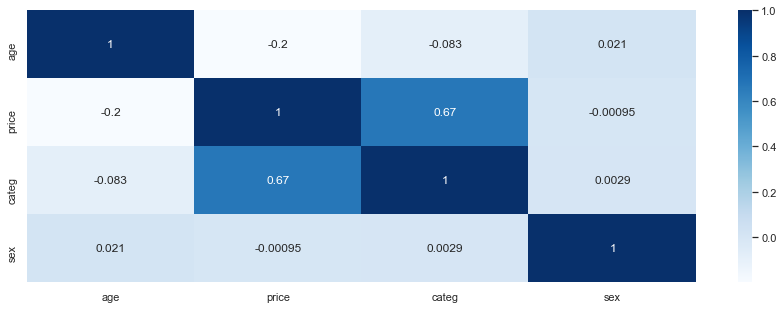

In [148]:
sns.heatmap(correl.corr(), annot= True, cmap = 'Blues')

# Correlations

In [149]:
conti_table = fusion.groupby(['sex', 'categ'])['date'].count().unstack()
conti_table_total = fusion.pivot_table('date', index = 'sex', columns = 'categ', aggfunc = 'count', margins = True, margins_name= 'Total')

In [150]:
conti_table

categ       0      1     2
sex                       
f      101148  53774  8122
m       94023  48851  7634

In [151]:
[chi2, pvalue, freedom, expected] = st.chi2_contingency(conti_table)
chi2

10.202417277273174

In [152]:
fusion.groupby('age')['price'].sum()

age
17    295387.98
18     88461.39
19     89910.02
20     84881.48
21     80099.92
        ...    
88      2632.02
89      2586.09
90      1432.92
91      2028.35
92      1300.03
Name: price, Length: 76, dtype: float64

In [153]:
test = fusion.groupby('age')['price'].sum()
[corr_score, pvalue] = st.pearsonr(test.index, test)
corr_score, pvalue

(-0.8277604829272697, 2.973659991894871e-20)

<AxesSubplot:xlabel='age', ylabel='price'>

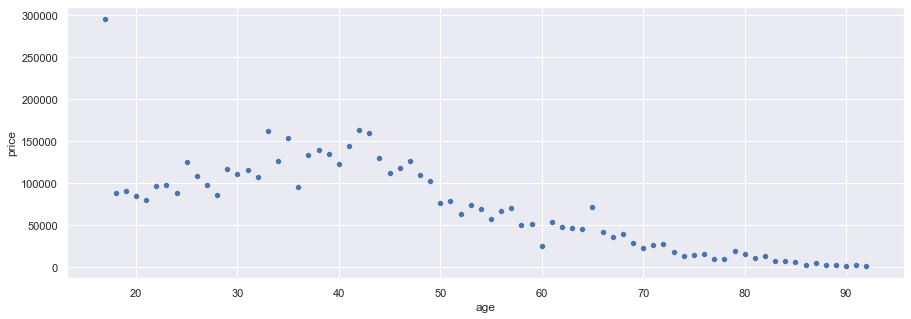

In [157]:
sns.scatterplot(x= test.index, y = test)